In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# download zip file from github
!wget https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip

--2023-04-11 22:21:13--  https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66764119 (64M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  63.67M   325MB/s    in 0.2s    

2023-04-11 22:21:18 (325 MB/s) - ‘Dataset.zip’ saved [66764119/66764119]



In [3]:
# create folder 
!mkdir dataset

In [4]:
# unzip data
!unzip /content/Dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/mnist_middle_columns/26957.jpg  
  inflating: /content/dataset/mnist_middle_columns/83.csv  
  inflating: /content/dataset/mnist_middle_columns/4921.csv  
  inflating: /content/dataset/mnist_middle_columns/34436.jpg  
  inflating: /content/dataset/mnist_middle_columns/28228.csv  
  inflating: /content/dataset/mnist_middle_columns/11910.csv  
  inflating: /content/dataset/mnist_middle_columns/24492.jpg  
  inflating: /content/dataset/mnist_middle_columns/32617.jpg  
  inflating: /content/dataset/mnist_middle_columns/57638.csv  
  inflating: /content/dataset/mnist_middle_columns/37617.csv  
  inflating: /content/dataset/mnist_middle_columns/35601.jpg  
  inflating: /content/dataset/mnist_middle_columns/42223.csv  
  inflating: /content/dataset/mnist_middle_columns/24519.csv  
  inflating: /content/dataset/mnist_middle_columns/40571.csv  
  inflating: /content/dataset/mnist_middle_columns/54769.jpg  
  inflat

In [5]:
# get list path of all images path with jpg format
import glob 
paths = glob.glob('/content/dataset/mnist_middle_columns/*.jpg')
paths[0]

'/content/dataset/mnist_middle_columns/12050.jpg'

In [6]:
split_size = 0.8
train_size = int(split_size * len(paths))
train_paths = paths[:train_size]
test_paths = paths[train_size:]
print(f'train size : {len(train_paths)}, test size : {len(test_paths)}')

train size : 48000, test size : 12000


In [7]:
csv_path = paths[0].replace('.jpg','.csv')
csv_path

'/content/dataset/mnist_middle_columns/12050.csv'

In [8]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image_array = np.array(image)
        image_array = image_array[:,:,0]
        image_array = image_array/255
        csv_path = image_path.replace('.jpg', '.csv')
        df = pd.read_csv(csv_path)
        target = df['0'].values
        target = torch.tensor(target)

  

        # flatten 2d image to 1d array
        features = image_array.reshape(28*28)
        features = torch.tensor(features)
        return features.float(), target.float()

In [9]:
train_dataset = CustomImageDataset(train_paths)
test_dataset = CustomImageDataset(test_paths)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader (test_dataset, batch_size = 64, shuffle = True)

In [11]:
import torch.nn as nn

In [ ]:
#build neural network
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.relu(x)
    x = self.hidden1(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
net

NeuralNetwork(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (hidden1): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=28, bias=True)
)

In [ ]:
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.048974 	test Loss: 0.030686
Epoch: 2 	Training Loss: 0.028074 	test Loss: 0.025852
Epoch: 3 	Training Loss: 0.024696 	test Loss: 0.023393
Epoch: 4 	Training Loss: 0.022664 	test Loss: 0.021768
Epoch: 5 	Training Loss: 0.021255 	test Loss: 0.020581
Epoch: 6 	Training Loss: 0.020189 	test Loss: 0.019733
Epoch: 7 	Training Loss: 0.019336 	test Loss: 0.018874
Epoch: 8 	Training Loss: 0.018654 	test Loss: 0.018263
Epoch: 9 	Training Loss: 0.018088 	test Loss: 0.017731
Epoch: 10 	Training Loss: 0.017595 	test Loss: 0.017333


Training process has finished.


In [19]:
data, target = next(iter(test_dataloader))
net.eval()
output = net(data)
print(output.shape)

torch.Size([64, 28])


In [20]:
data = data.reshape(64, 28, 28)


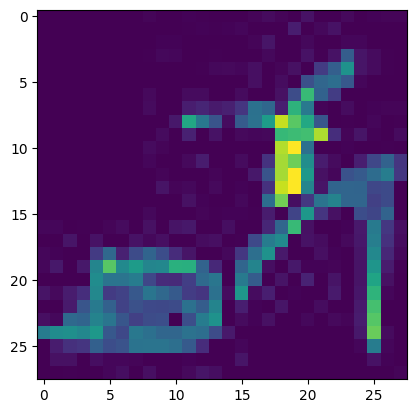

In [ ]:
plt.imshow(data[0, :, :].detach().numpy())

In [ ]:
data[0:, :, 14] = output[0, :]

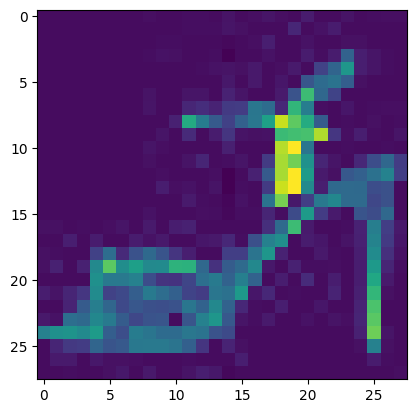

In [ ]:
plt.imshow(data[0, :, :].detach().numpy())
# plt.savefig("0.jpg")

**Batch Normalization layers**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.027353 	test Loss: 0.021017
Epoch: 2 	Training Loss: 0.022368 	test Loss: 0.018765
Epoch: 3 	Training Loss: 0.020395 	test Loss: 0.018021
Epoch: 4 	Training Loss: 0.019367 	test Loss: 0.017153
Epoch: 5 	Training Loss: 0.018721 	test Loss: 0.016565
Epoch: 6 	Training Loss: 0.017910 	test Loss: 0.015928
Epoch: 7 	Training Loss: 0.017370 	test Loss: 0.015897
Epoch: 8 	Training Loss: 0.016974 	test Loss: 0.015214
Epoch: 9 	Training Loss: 0.016694 	test Loss: 0.015250
Epoch: 10 	Training Loss: 0.016326 	test Loss: 0.015131


Training process has finished.


**Dropout layers**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self,dropout_rate):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron
    self.dropout = nn.Dropout(dropout_rate) # add dropout layer with specified dropout rate

  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    x = self.dropout(x) #dropout for the first hidden layer

    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.dropout(x) #dropout for the second hidden layer
    x = self.output(x)

    return x

In [ ]:
dropout_rate = 0.5 # specify the dropout rate
net = NeuralNetwork(dropout_rate)
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.076585 	test Loss: 0.041085
Epoch: 2 	Training Loss: 0.036072 	test Loss: 0.042482
Epoch: 3 	Training Loss: 0.034008 	test Loss: 0.029747
Epoch: 4 	Training Loss: 0.032600 	test Loss: 0.032341
Epoch: 5 	Training Loss: 0.031634 	test Loss: 0.030758
Epoch: 6 	Training Loss: 0.030756 	test Loss: 0.028899
Epoch: 7 	Training Loss: 0.030137 	test Loss: 0.029741
Epoch: 8 	Training Loss: 0.029749 	test Loss: 0.025517
Epoch: 9 	Training Loss: 0.029345 	test Loss: 0.024142
Epoch: 10 	Training Loss: 0.028888 	test Loss: 0.024998


Training process has finished.


**Activation function --->Sigmoid**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.sigmoid = torch.nn.Sigmoid()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.sigmoid = torch.nn.Sigmoid()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.sigmoid(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.sigmoid(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.033275 	test Loss: 0.022024
Epoch: 2 	Training Loss: 0.022627 	test Loss: 0.019482
Epoch: 3 	Training Loss: 0.020875 	test Loss: 0.018057
Epoch: 4 	Training Loss: 0.019775 	test Loss: 0.017770
Epoch: 5 	Training Loss: 0.018967 	test Loss: 0.017102
Epoch: 6 	Training Loss: 0.018648 	test Loss: 0.016466
Epoch: 7 	Training Loss: 0.018138 	test Loss: 0.015980
Epoch: 8 	Training Loss: 0.017959 	test Loss: 0.017030
Epoch: 9 	Training Loss: 0.017626 	test Loss: 0.015287
Epoch: 10 	Training Loss: 0.017234 	test Loss: 0.015059


Training process has finished.


**Activation function ---> leaky ReLU**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.l_relu = torch.nn.LeakyReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.l_relu = torch.nn.LeakyReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.l_relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.l_relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.037348 	test Loss: 0.022942
Epoch: 2 	Training Loss: 0.023226 	test Loss: 0.019437
Epoch: 3 	Training Loss: 0.020841 	test Loss: 0.018261
Epoch: 4 	Training Loss: 0.019650 	test Loss: 0.017016
Epoch: 5 	Training Loss: 0.018745 	test Loss: 0.016413
Epoch: 6 	Training Loss: 0.018065 	test Loss: 0.016201
Epoch: 7 	Training Loss: 0.017687 	test Loss: 0.015543
Epoch: 8 	Training Loss: 0.016986 	test Loss: 0.015292
Epoch: 9 	Training Loss: 0.016709 	test Loss: 0.015787
Epoch: 10 	Training Loss: 0.016284 	test Loss: 0.014734


Training process has finished.


**Learning Rate Scheduling Techniques**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.l_relu = torch.nn.LeakyReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.l_relu = torch.nn.LeakyReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.l_relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.l_relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    if scheduler is not None:
            scheduler.step()
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.029470 	test Loss: 0.021600
Epoch: 2 	Training Loss: 0.022754 	test Loss: 0.019403
Epoch: 3 	Training Loss: 0.020711 	test Loss: 0.017907
Epoch: 4 	Training Loss: 0.019569 	test Loss: 0.016940
Epoch: 5 	Training Loss: 0.018680 	test Loss: 0.016560
Epoch: 6 	Training Loss: 0.017952 	test Loss: 0.015872
Epoch: 7 	Training Loss: 0.017363 	test Loss: 0.015947
Epoch: 8 	Training Loss: 0.016944 	test Loss: 0.015457
Epoch: 9 	Training Loss: 0.016725 	test Loss: 0.015225
Epoch: 10 	Training Loss: 0.016344 	test Loss: 0.014953


Training process has finished.


**L1 regularization**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        l1_reg = torch.tensor(0.)
        for name, param in net.named_parameters():
            if 'weight' in name:
                l1_reg += torch.norm(param, 1)
        loss += 0.001 * l1_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 3.593806 	test Loss: 0.067247
Epoch: 2 	Training Loss: 1.032543 	test Loss: 0.042330
Epoch: 3 	Training Loss: 0.935409 	test Loss: 0.028120
Epoch: 4 	Training Loss: 0.850389 	test Loss: 0.036138
Epoch: 5 	Training Loss: 0.768515 	test Loss: 0.040081
Epoch: 6 	Training Loss: 0.688521 	test Loss: 0.037845
Epoch: 7 	Training Loss: 0.609217 	test Loss: 0.025165
Epoch: 8 	Training Loss: 0.530249 	test Loss: 0.025236
Epoch: 9 	Training Loss: 0.452000 	test Loss: 0.029396
Epoch: 10 	Training Loss: 0.373501 	test Loss: 0.028119


Training process has finished.


**L2 regularization**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        l2_reg = torch.tensor(0.)
        for name, param in net.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, 2)**2
        loss += 0.001 * l2_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 1.224604 	test Loss: 0.021259
Epoch: 2 	Training Loss: 0.901311 	test Loss: 0.018384
Epoch: 3 	Training Loss: 0.671134 	test Loss: 0.016702
Epoch: 4 	Training Loss: 0.501213 	test Loss: 0.015909
Epoch: 5 	Training Loss: 0.375810 	test Loss: 0.015207
Epoch: 6 	Training Loss: 0.283153 	test Loss: 0.014658
Epoch: 7 	Training Loss: 0.214954 	test Loss: 0.014537
Epoch: 8 	Training Loss: 0.164802 	test Loss: 0.014164
Epoch: 9 	Training Loss: 0.127669 	test Loss: 0.013843
Epoch: 10 	Training Loss: 0.100718 	test Loss: 0.014955


Training process has finished.


**Different optimizers and comparing their performance ----> ADAM**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.Adam(net.parameters(), lr = 0.01) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.043971 	test Loss: 0.018793
Epoch: 2 	Training Loss: 0.018820 	test Loss: 0.016699
Epoch: 3 	Training Loss: 0.016216 	test Loss: 0.014135
Epoch: 4 	Training Loss: 0.015074 	test Loss: 0.014278
Epoch: 5 	Training Loss: 0.014496 	test Loss: 0.014591
Epoch: 6 	Training Loss: 0.014128 	test Loss: 0.013767
Epoch: 7 	Training Loss: 0.013725 	test Loss: 0.013279
Epoch: 8 	Training Loss: 0.013458 	test Loss: 0.012873
Epoch: 9 	Training Loss: 0.013323 	test Loss: 0.013425
Epoch: 10 	Training Loss: 0.013116 	test Loss: 0.012814


Training process has finished.


**Different optimizers and comparing their performance ----> ADAGRAD**

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [ ]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.Adagrad(net.parameters(), lr = 0.01) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
      
      output = net(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)

    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.031382 	test Loss: 0.018181
Epoch: 2 	Training Loss: 0.018399 	test Loss: 0.016620
Epoch: 3 	Training Loss: 0.016510 	test Loss: 0.014862
Epoch: 4 	Training Loss: 0.015297 	test Loss: 0.014436
Epoch: 5 	Training Loss: 0.014624 	test Loss: 0.013161
Epoch: 6 	Training Loss: 0.014079 	test Loss: 0.012936
Epoch: 7 	Training Loss: 0.013651 	test Loss: 0.012815
Epoch: 8 	Training Loss: 0.013252 	test Loss: 0.012439
Epoch: 9 	Training Loss: 0.012979 	test Loss: 0.012638
Epoch: 10 	Training Loss: 0.012730 	test Loss: 0.012682


Training process has finished.


***Different Weight initialization ***

In [15]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [16]:
net1= NeuralNetwork()
import torch.optim as optim
net1.train()
optimizer = optim.SGD(net1.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

In [17]:
import torch.nn.init as init

# Zero initialization
init.zeros_(net1.hidden.weight)
init.zeros_(net1.hidden1.weight)

print("Zero initialization:")
print(net1.hidden.weight)
print(net1.hidden1.weight)

Zero initialization:
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)


In [18]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net1.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net1(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net1.eval()
    for data, target in test_dataloader:
      
      output = net1(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net1.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.036458 	test Loss: 0.019248
Epoch: 2 	Training Loss: 0.019422 	test Loss: 0.016339
Epoch: 3 	Training Loss: 0.017436 	test Loss: 0.015633
Epoch: 4 	Training Loss: 0.016254 	test Loss: 0.014989
Epoch: 5 	Training Loss: 0.015511 	test Loss: 0.014594
Epoch: 6 	Training Loss: 0.014905 	test Loss: 0.013814
Epoch: 7 	Training Loss: 0.014536 	test Loss: 0.013716
Epoch: 8 	Training Loss: 0.014181 	test Loss: 0.013579
Epoch: 9 	Training Loss: 0.013964 	test Loss: 0.013374
Epoch: 10 	Training Loss: 0.013751 	test Loss: 0.013452


Training process has finished.


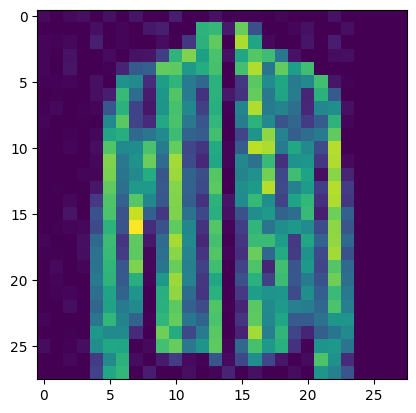

In [21]:
plt.imshow(data[0, :, :].detach().numpy())

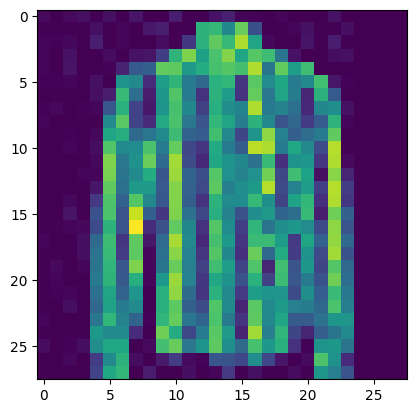

In [22]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

In [ ]:
net2= NeuralNetwork()
net2.train()
optimizer = optim.SGD(net2.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function

# Random initialization
init.normal_(net2.hidden.weight, mean=0.0, std=1.0)

print("Random initialization:")
print(net2.hidden.weight)
print(net2.hidden1.weight)

Random initialization:
Parameter containing:
tensor([[ 1.8563e+00,  1.3903e+00, -7.9119e-01,  ..., -1.9370e-01,
          4.0537e-01, -5.5794e-01],
        [-4.0632e-01, -2.0427e+00,  6.2392e-01,  ...,  2.0791e-01,
          5.0449e-01,  4.4646e-01],
        [-5.5061e-01, -5.4962e-01,  7.8421e-01,  ...,  1.8549e+00,
         -8.4087e-02,  7.9605e-01],
        ...,
        [-1.0976e+00,  1.1811e+00,  1.4498e+00,  ..., -1.4371e+00,
         -5.3048e-01,  1.6026e+00],
        [ 6.3806e-01, -4.4344e-01,  6.7821e-01,  ...,  5.5075e-01,
          1.5062e+00, -6.0346e-01],
        [ 1.0685e+00, -1.4476e-03,  1.9548e+00,  ..., -3.2066e-01,
         -8.7478e-02, -1.5380e+00]], requires_grad=True)
Parameter containing:
tensor([[-0.0012, -0.0113, -0.0242,  ..., -0.0067, -0.0187, -0.0168],
        [-0.0066,  0.0283,  0.0178,  ..., -0.0373,  0.0411, -0.0167],
        [ 0.0401, -0.0088,  0.0250,  ..., -0.0228, -0.0146, -0.0152],
        ...,
        [ 0.0408,  0.0292,  0.0020,  ...,  0.0019,  0.0021

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net2.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net2.eval()
    for data, target in test_dataloader:
      
      output = net2(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net2.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.044696 	test Loss: 0.026532
Epoch: 2 	Training Loss: 0.026619 	test Loss: 0.022858
Epoch: 3 	Training Loss: 0.023906 	test Loss: 0.021101
Epoch: 4 	Training Loss: 0.022661 	test Loss: 0.019995
Epoch: 5 	Training Loss: 0.021651 	test Loss: 0.019382
Epoch: 6 	Training Loss: 0.021068 	test Loss: 0.019172
Epoch: 7 	Training Loss: 0.020677 	test Loss: 0.018925
Epoch: 8 	Training Loss: 0.020289 	test Loss: 0.018370
Epoch: 9 	Training Loss: 0.019876 	test Loss: 0.018039
Epoch: 10 	Training Loss: 0.019706 	test Loss: 0.018018


Training process has finished.


In [ ]:
# He initialization
net3= NeuralNetwork()
import torch.optim as optim
net3.train()
optimizer = optim.SGD(net3.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
init.kaiming_normal_(net3.hidden.weight, mode='fan_in', nonlinearity='relu')

print("He initialization:")
print(net3.hidden.weight)
print(net3.hidden1.weight)

He initialization:
Parameter containing:
tensor([[-0.0293, -0.0229, -0.0052,  ..., -0.0129, -0.0919, -0.0333],
        [ 0.0237,  0.0106,  0.0184,  ..., -0.0841, -0.0644,  0.0090],
        [-0.1112, -0.0556, -0.0267,  ..., -0.0798, -0.0284, -0.0265],
        ...,
        [ 0.0109,  0.0085, -0.0100,  ..., -0.0131,  0.0037,  0.0546],
        [ 0.0085, -0.0004,  0.0056,  ...,  0.0163, -0.0336, -0.0581],
        [-0.0458,  0.0054,  0.0397,  ..., -0.0719, -0.0572, -0.0284]],
       requires_grad=True)
Parameter containing:
tensor([[-3.8818e-02,  1.1284e-03, -3.9876e-02,  ...,  2.8084e-02,
          1.7013e-02,  1.4230e-02],
        [ 3.4766e-02, -1.6519e-02, -4.0292e-02,  ...,  2.4644e-04,
         -3.9073e-02, -1.1619e-02],
        [-1.7200e-02, -1.5690e-03, -4.3235e-02,  ...,  3.6157e-02,
          1.0116e-02,  3.5065e-02],
        ...,
        [-3.0547e-02,  3.3970e-02, -2.1501e-02,  ..., -4.0314e-02,
          1.9857e-02,  2.7688e-02],
        [-5.6427e-03,  3.5712e-02,  3.1922e-02,  ..

In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net3.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net3.eval()
    for data, target in test_dataloader:
      
      output = net3(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net3.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.042716 	test Loss: 0.025136
Epoch: 2 	Training Loss: 0.025454 	test Loss: 0.021502
Epoch: 3 	Training Loss: 0.022841 	test Loss: 0.019618
Epoch: 4 	Training Loss: 0.021613 	test Loss: 0.019057
Epoch: 5 	Training Loss: 0.020674 	test Loss: 0.018568
Epoch: 6 	Training Loss: 0.020110 	test Loss: 0.017937
Epoch: 7 	Training Loss: 0.019419 	test Loss: 0.017720
Epoch: 8 	Training Loss: 0.019157 	test Loss: 0.017195
Epoch: 9 	Training Loss: 0.018633 	test Loss: 0.017038
Epoch: 10 	Training Loss: 0.018251 	test Loss: 0.016769


Training process has finished.


In [ ]:
# Xavier initialization
net4= NeuralNetwork()
net4.train()
optimizer = optim.SGD(net4.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
init.xavier_normal_(net4.hidden.weight, gain=1.0)

print("Xavier initialization:")
print(net4.hidden.weight)
print(net4.hidden1.weight)

Xavier initialization:
Parameter containing:
tensor([[-0.0137, -0.0060,  0.0209,  ...,  0.0379, -0.0641,  0.0516],
        [-0.0284,  0.0168, -0.0497,  ...,  0.0262,  0.0115, -0.0101],
        [ 0.0523,  0.0234, -0.0605,  ..., -0.0267,  0.0112,  0.0337],
        ...,
        [ 0.0249,  0.0145,  0.0094,  ..., -0.0331,  0.0658, -0.0104],
        [ 0.0049,  0.0638, -0.0117,  ...,  0.0128,  0.0469, -0.0116],
        [-0.0425,  0.0364,  0.0110,  ..., -0.0578,  0.0153,  0.0226]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0400,  0.0218, -0.0350,  ...,  0.0187,  0.0119, -0.0005],
        [ 0.0440, -0.0191,  0.0291,  ...,  0.0359,  0.0027, -0.0406],
        [-0.0269, -0.0066, -0.0356,  ...,  0.0139,  0.0430, -0.0023],
        ...,
        [-0.0067, -0.0267,  0.0419,  ...,  0.0062, -0.0212, -0.0008],
        [-0.0358, -0.0260, -0.0092,  ..., -0.0439, -0.0004, -0.0363],
        [-0.0033, -0.0099, -0.0008,  ..., -0.0253, -0.0014,  0.0336]],
       requires_grad=True)


In [ ]:
n_epochs = 10
test_loss_min = np.Inf 


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net4.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net4(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net4.eval()
    for data, target in test_dataloader:
      
      output = net4(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    
    if test_loss <= test_loss_min:
        
        torch.save(net4.state_dict(), 'model.pt')
        test_loss_min = test_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.041327 	test Loss: 0.025289
Epoch: 2 	Training Loss: 0.024887 	test Loss: 0.020949
Epoch: 3 	Training Loss: 0.022551 	test Loss: 0.019412
Epoch: 4 	Training Loss: 0.021309 	test Loss: 0.018532
Epoch: 5 	Training Loss: 0.020442 	test Loss: 0.018032
Epoch: 6 	Training Loss: 0.019618 	test Loss: 0.017329
Epoch: 7 	Training Loss: 0.019087 	test Loss: 0.017022
Epoch: 8 	Training Loss: 0.018646 	test Loss: 0.016728
Epoch: 9 	Training Loss: 0.018250 	test Loss: 0.016481
Epoch: 10 	Training Loss: 0.017891 	test Loss: 0.016220


Training process has finished.


**EarlyStopping**

In [12]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = torch.nn.Linear(28 * 28, 512) #input layer with 784 neuron 
    self.relu = torch.nn.ReLU()
    self.bnormal1 = nn.BatchNorm1d(512)
    self.hidden1 = torch.nn.Linear(512, 512) #hidden layer with 512 neuron
    self.relu = torch.nn.ReLU()
    self.bnormal2 = nn.BatchNorm1d(512)
    self.output = torch.nn.Linear(512, 28) #output layer with 512 neuron


  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)
    x = self.hidden(x)
    x = self.bnormal1(x)
    x = self.relu(x)
    
    x = self.hidden1(x)
    x = self.bnormal2(x)
    x = self.relu(x)
    x = self.output(x)

    return x

In [13]:
net = NeuralNetwork()
import torch.optim as optim
net.train()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9) # Define the optimizer
criterion = nn.MSELoss() #Define the loss function
n_epochs = 10

In [14]:
test_loss_min = np.Inf # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
 
    net.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    net.eval()
    for data, target in test_dataloader:
        output = net(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    test_loss = test_loss/len(test_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \ttest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(net.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease

    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

print('\n')
print('Process has finished.')

Epoch: 1 	Training Loss: 0.037153 	test Loss: 0.022506
Model saved - Validation loss decreased from inf to 0.022506
Epoch: 2 	Training Loss: 0.023056 	test Loss: 0.019378
Model saved - Validation loss decreased from 0.022506 to 0.019378
Epoch: 3 	Training Loss: 0.020805 	test Loss: 0.018036
Model saved - Validation loss decreased from 0.019378 to 0.018036
Epoch: 4 	Training Loss: 0.019507 	test Loss: 0.017180
Model saved - Validation loss decreased from 0.018036 to 0.017180
Epoch: 5 	Training Loss: 0.018743 	test Loss: 0.017138
Model saved - Validation loss decreased from 0.017180 to 0.017138
Epoch: 6 	Training Loss: 0.018060 	test Loss: 0.016139
Model saved - Validation loss decreased from 0.017138 to 0.016139
Epoch: 7 	Training Loss: 0.017416 	test Loss: 0.016036
Model saved - Validation loss decreased from 0.016139 to 0.016036
Epoch: 8 	Training Loss: 0.016941 	test Loss: 0.015265
Model saved - Validation loss decreased from 0.016036 to 0.015265
Epoch: 9 	Training Loss: 0.016608 	te